In [1]:
library("ape")
library("phytools")
library("caper")
library("geiger")
library("readxl")
library("tidyverse")

Loading required package: maps

Loading required package: MASS

Loading required package: mvtnorm

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::map()    masks maps::map()
✖ dplyr::select() masks MASS::select()
✖ dplyr::where()  masks ape::where()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) t

In [2]:
load_and_process_csv <- function(csv_filename) {
    df <- read.csv(csv_filename)
    rownames(df) <- df$species
    df$log_u <- log10(df$u_mean)
    df$log_u_year <- log10(df$u_mean_year)
    df$log_Ne <- log10(df$Ne)
    df$log_Ne.gen <- log10(df$Ne.gen)
    df$log_gen_year <- log10(df$generation_time_year)
    df = dplyr::select(df, species, log_u, log_u_year, log_Ne, log_Ne.gen, log_gen_year)
    return(df)
}

load_tree_and_modify_species_name <- function(tree_filename) {
    tree <- read.tree(tree_filename)
    # the tree should be both binary and ultrametric
    stopifnot(is.binary(tree)) 
    stopifnot(is.ultrametric(tree))
    # 126 species, 250 edges
    length(tree$tip.label) 
    # plot(tree)
    
    # replace all _ in tree species name to space
    for(nn in tree$tip.label){
      tmp <- stringr::str_replace_all(nn,'_', ' ')
      tree$tip.label <- 
        stringr::str_replace_all(tree$tip.label, nn, tmp)
    }
    return(tree)
}

trim_tree_branches <- function (tree, df) {
    # trim off tree branches corresponding to species that are not found in the dataframe
    name_check <- name.check(tree, df)
    new_tree <- drop.tip(tree, name_check$tree_not_data)
    name.check(new_tree, df)
    return(new_tree)
}

pgls_dbh <- function(df, tree, x_name, y_name, lambda, print_plot) {
    taxa <- comparative.data(tree, df, "species", vcv=TRUE)
    fm <- as.formula(paste(y_name, "~", x_name))
    model <- pgls(formula=fm, data=taxa, lambda=lambda)
    coeff <- coefficients(model)
    intercept <- coeff[1]
    slope <- coeff[2]
    Ne_u_plot <- ggplot(data=df, aes_string(x=x_name, y=y_name)) + geom_point()
    Ne_u_plot <- Ne_u_plot + geom_smooth(formula=y~x, method="lm") + geom_abline(intercept = intercept, slope = slope)
    if (print_plot) {
        print(Ne_u_plot + labs(y=y_name, x=x_name))
    }

    res<- residuals(model, phylo = TRUE)
    res<- res/sqrt(var(res))[1]
    
    return(model)
}

save_summary_data <- function(model, print_output, save_output, save_filename="output_file.csv") {
    model_summary <- summary(model)
    # names(summary(model_summary))
    lambda <- model_summary$param.CI$lambda$opt
    lambda.ci.val <- model_summary$param.CI$lambda$ci.val
    lambda.bounds <- model_summary$param.CI$lambda$bounds.val
    lambda.p <- model_summary$param.CI$lambda$bounds.p
    
    coeff <- model_summary$coefficients[,1]
    coeff.p <- model_summary$coefficients[,4]
    if (print_output) {
        cat("lambda: ", lambda, ", CI of lambda: ", lambda.ci.val, "\n")
        cat("coefficients: ", coeff, ", p-value: ", coeff.p, "\n")
    }

    if (save_output) {
        df_out <- t(data.frame(c(lambda, lambda.ci.val, lambda.bounds, lambda.p, coeff, coeff.p)))
        colnames(df_out) <- c("lambda", "lambda.ci.low", "lambda.ci.high", "lambda.bounds.low", "lambda.bounds.high", "lambda.p.low", "lambda.p.high", "intercept", "slope", "intercept.p", "slope.p")
        rownames(df_out) <- c(1)
        write.csv(df_out, save_filename)
    }
}

## Wang's data and tree

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


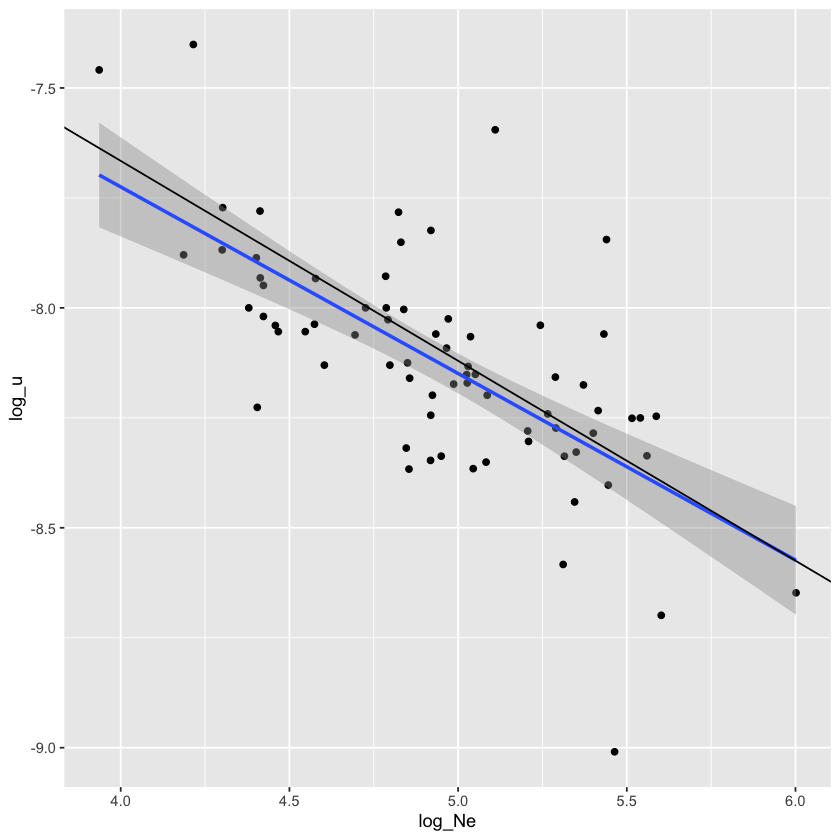

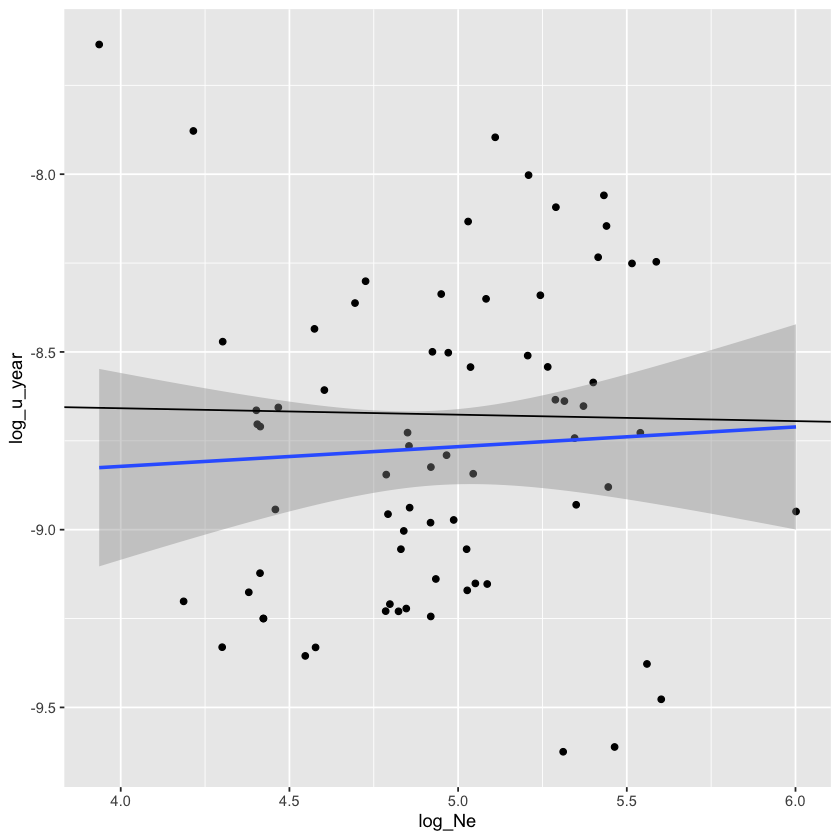

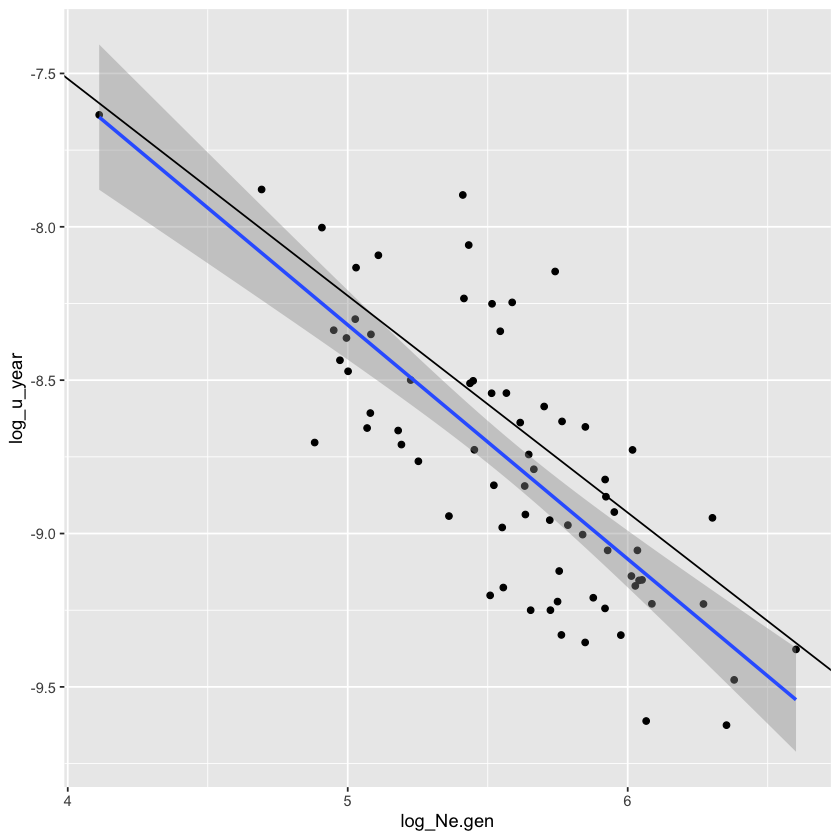

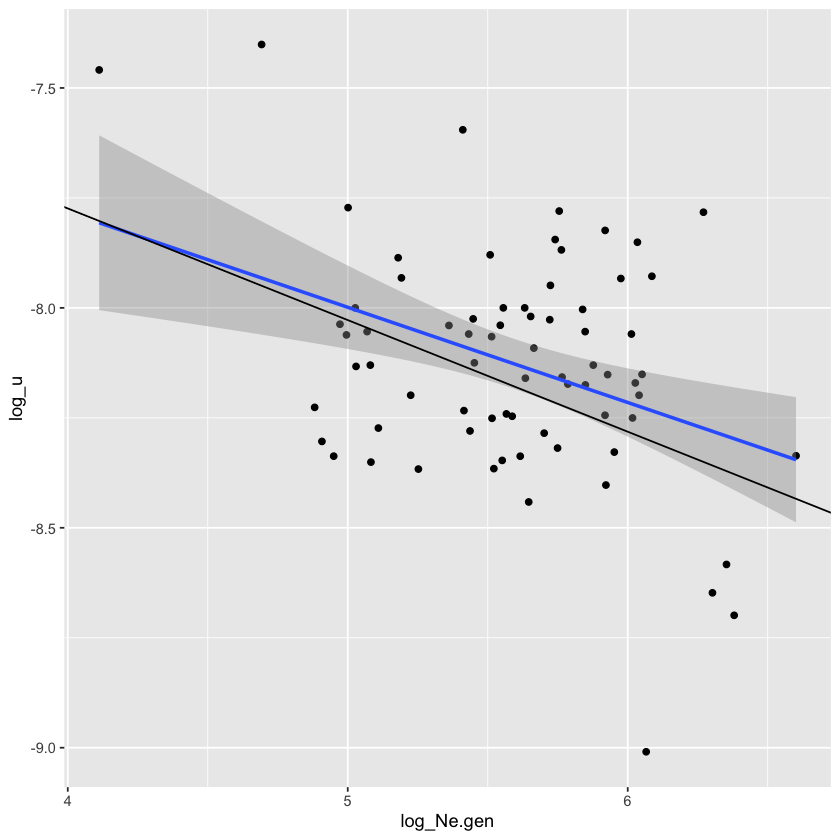

In [3]:
# df <- load_and_process_csv("./output/processed_mutation_rate_estimate.csv")
df <- load_and_process_csv("./output/df_vertebrate.csv")

tree_filename <- "./data/filtered_unique_species.nwk"
tree <- load_tree_and_modify_species_name(tree_filename)
new_tree <- trim_tree_branches(tree, df)

lambda = "ML" 

Ne_u.pgls <- pgls_dbh(df, new_tree, "log_Ne", "log_u", lambda=lambda, print_plot=TRUE)
# summary(Ne_u.pgls)
# lambda_profile <- pgls.profile(Ne_u.pgls, which="lambda") # vary lambda
# plot(lambda_profile)
 
Ne_u_year.pgls <- pgls_dbh(df, new_tree, "log_Ne", "log_u_year", lambda=lambda, print_plot=TRUE)
# summary(Ne_u_year.pgls)

Negen_u_year.pgls <- pgls_dbh(df, new_tree, "log_Ne.gen", "log_u_year", lambda=lambda, print_plot=TRUE)
# summary(Negen_u_year.pgls)

Negen_u.pgls <- pgls_dbh(df, new_tree, "log_Ne.gen", "log_u", lambda=lambda, print_plot=TRUE)
# summary(Negen_u.pgls)

print_output=FALSE
save_output=TRUE
save_summary_data(Ne_u.pgls, print_output=print_output, save_output=save_output, save_filename="output/r/dbh_vertebrate_Ne_u.csv")
save_summary_data(Ne_u_year.pgls, print_output=print_output, save_output=save_output, save_filename="output/r/dbh_vertebrate_Ne_u_year.csv")
save_summary_data(Negen_u_year.pgls, print_output=print_output, save_output=save_output, save_filename="output/r/dbh_vertebrate_Negen_u_year.csv")
save_summary_data(Negen_u.pgls, print_output=print_output, save_output=save_output, save_filename="output/r/dbh_vertebrate_Negen_u.csv")

## PGLS of effective population size vs generation time (year)


Call:
pgls(formula = fm, data = taxa, lambda = lambda)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.112023 -0.024400  0.004709  0.019378  0.073704 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.944
   lower bound : 0.000, p = 0.0097167
   upper bound : 1.000, p = 5.6741e-12
   95.0% CI   : (0.658, 0.985)
delta  [Fix]  : 1.000

Coefficients:
             Estimate Std. Error t value  Pr(>|t|)    
(Intercept)   5.39197    0.34872 15.4623 < 2.2e-16 ***
log_gen_year -0.48743    0.11257 -4.3299 4.876e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03419 on 70 degrees of freedom
Multiple R-squared: 0.2113,	Adjusted R-squared:   0.2 
F-statistic: 18.75 on 1 and 70 DF,  p-value: 4.876e-05 

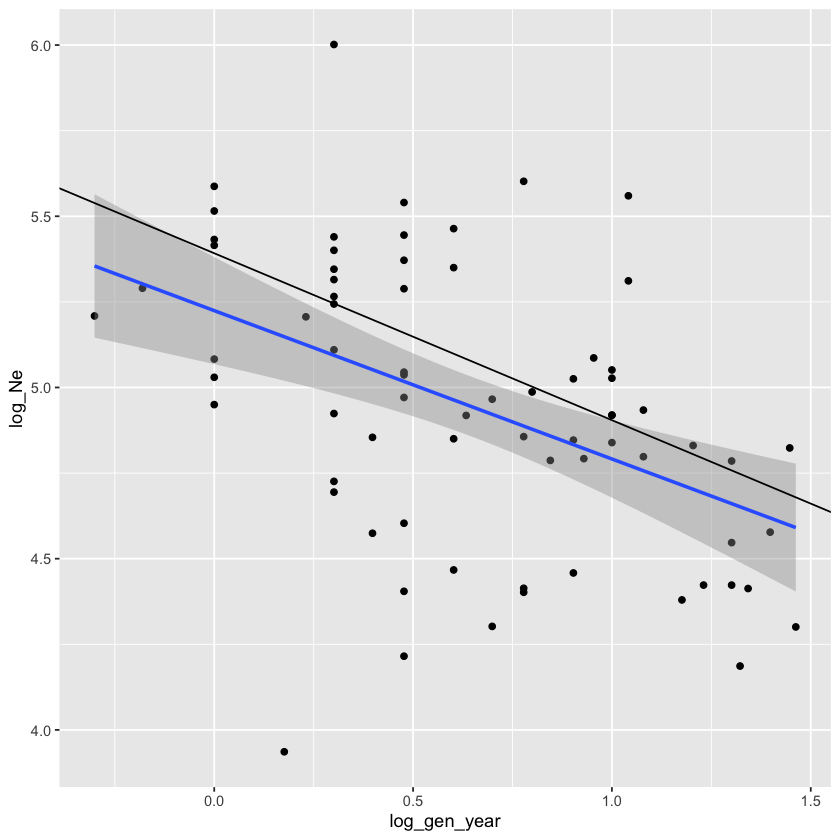

In [4]:
gen_Ne.pgls <- pgls_dbh(df, new_tree, "log_gen_year", "log_Ne", lambda=lambda, print_plot=TRUE)
summary(gen_Ne.pgls)
save_summary_data(gen_Ne.pgls, print_output=FALSE, save_output=TRUE, save_filename="output/r/gen_Ne.csv")

## Reviewer 1, yearly mutation rate vs generation time (year)

lambda 
0.9598813

[1] 0.8445579 0.9859679

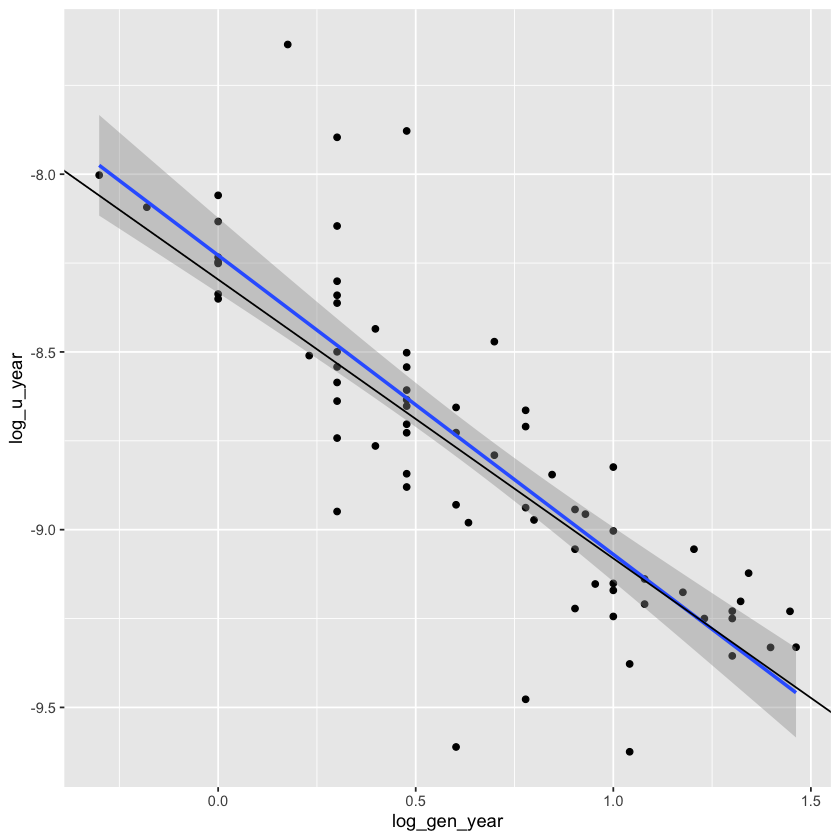

In [14]:
model.u_year.gen <- pgls_dbh(df, new_tree, "log_gen_year", "log_u_year", lambda=lambda, print_plot=TRUE)
summary(model.u_year.gen)$param.CI$lambda$opt
summary(model.u_year.gen)$param.CI$lambda$ci.val
save_summary_data(model.u_year.gen, print_output=FALSE, save_output=TRUE, save_filename="output/r/mu_gen.csv")

### Remove samples that are not present in Bergeron's dataset: no more phylogenetic signal

[1] 63

lambda 
 1e-06

[1]        NA 0.4104277

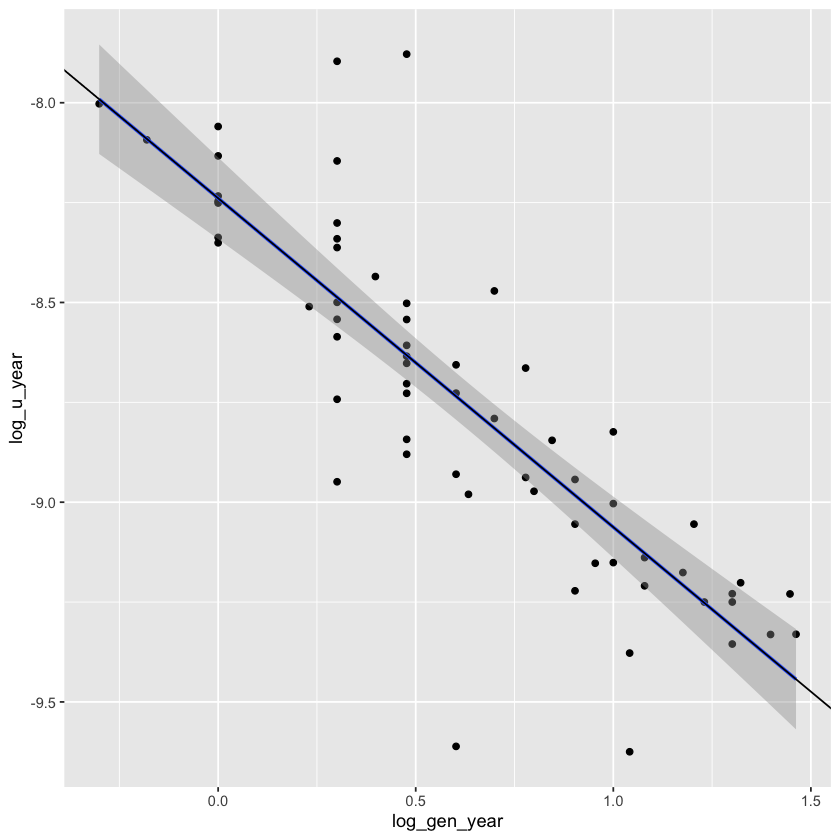

In [15]:
remove_samples = 'Macaca mulatta vestita|Ficedula albicollis|Callithrix jacchus|
Canis lupus lupus|Bos taurus|Pongo abelii|Chlorocebus sabaeus|Amphilophus labiatus|
Gorilla gorilla|Papio anubis|Clupea harengus'
df_inter <- df[-grep(remove_samples, rownames(df)),]
nrow(df_inter)
model.u_year.gen <- pgls_dbh(df_inter, new_tree, "log_gen_year", "log_u_year", lambda=lambda, print_plot=TRUE)
summary(model.u_year.gen)$param.CI$lambda$opt
summary(model.u_year.gen)$param.CI$lambda$ci.val